# BEZIER GAN

## Prep

### Import Modules

In [1]:
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import binom

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
BATCH_SIZE = 128
VAL_SIZE = 0.1
TRAIN_SIZE = 0.8

In [3]:
random.seed(420)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Load Data

In [5]:
AIRFOIL = np.load('airfoil_interp.npy')
np.random.shuffle(AIRFOIL)
AIRFOIL.shape

(1528, 192, 2)

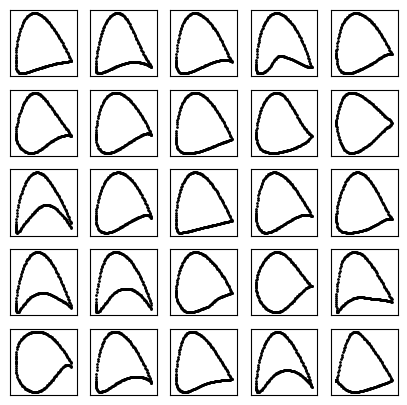

In [6]:
# check
def linear_plotter(images):
	fig = plt.figure(figsize=(5, 5))
	for i in range(25):
		ax = fig. add_subplot(5, 5, i+1, xticks=[], yticks=[])
		ax.scatter(images[i][0, :], images[i][1, :], c='black', s=1)
		ax.set_xlim(-0.1, 1.1)
		# ax.set_ylim(-0.6, 0.6)

AIRFOIL = AIRFOIL.transpose(0, 2, 1)
images = AIRFOIL[:25]
linear_plotter(images)

In [7]:
class CustomAirfoilDataset(Dataset):
    def __init__(self, airfoil_list):
        self.airfoils = airfoil_list
    def __getitem__(self, index):
        airfoil = self.airfoils[index]
        return airfoil
    def __len__(self):
        return len(self.airfoils)

airforil_dataset = CustomAirfoilDataset(torch.tensor(AIRFOIL).to(device))

data_size = len(airforil_dataset)
train_size = int(data_size * TRAIN_SIZE)
val_size = int(data_size * VAL_SIZE)
test_size = data_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(airforil_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE//8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE//8, shuffle=True, drop_last=True)

## Generator

In [8]:
def get_generator_linear_block(input_dim, output_dim):
  seq = nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.LeakyReLU(negative_slope=0.2, inplace=False),
      nn.Dropout(0.3),
  )
  return seq

def get_generator_deconv_1D_block(in_ch, out_ch, stride):
  seq = nn.Sequential(
      nn.ConvTranspose1d(in_channels=in_ch, out_channels=out_ch, kernel_size=stride + 2, stride=stride, padding=1),
      nn.BatchNorm1d(out_ch),
      nn.LeakyReLU(negative_slope=0.2, inplace=False),
      nn.Dropout(0.3),
  )
  return seq

### Gen-C1 b

In [9]:
class Generator(nn.Module):
  def __init__(self, z_dim, c_dim, point_dim, param_dim, sample_dim): # out dim % 4 == 0
    super(Generator, self).__init__()

    self.point_dim = point_dim
    self.param_dim = param_dim
    self.sample_dim = sample_dim
    with torch.no_grad():
      self.linear_samples = torch.tensor(np.linspace(0, 1, self.sample_dim//2 + 1), device=device)
      self.linear_points = torch.tensor(np.arange(point_dim//2 + 2), device=device)
      self.combination = torch.tensor(binom(point_dim//2 + 1, np.arange(point_dim//2 + 2)), device=device)

    self.gen_points = nn.Sequential(
      get_generator_linear_block(z_dim + c_dim, 256 * point_dim // 4),
      nn.Unflatten(1, (256, point_dim // 4)),
      get_generator_deconv_1D_block(256, 128, 2),
      get_generator_deconv_1D_block(128, 64, 2),
      get_generator_deconv_1D_block(64, 32, 2),
      nn.Conv1d(in_channels=32, out_channels=3, kernel_size=2 + 2, stride=2, padding=1),
      nn.Tanh()
    )

    self.gen_kernel = nn.Sequential(
      get_generator_linear_block(z_dim + c_dim, 32 * param_dim // 2),
      nn.Unflatten(1, (32, param_dim // 2)),
      get_generator_deconv_1D_block(32, 16, 2),
      get_generator_deconv_1D_block(16, 8, 2),
      nn.Conv1d(in_channels=8, out_channels=3, kernel_size=2 + 2, stride=2, padding=1),
      nn.Tanh()
    )


  def bezier(self, p, w, s, former=True):
    # p(batch, 2, point + 3)
    # w(batch, 1, point + 3)
    # s(batch, 3, param)
    # self.combination(point + 3,)
    # self.linear_points(point + 3,)
    # self.linear_samples(sample,)

    s = s.unsqueeze(-1) # s(batch, 3, param, 1)
    u = self.linear_samples[1:-1] # u(sample - 2,)
    u = (s[:, 2, :, :] * (1 - (1 - u) ** (1 / s[:, 1, :, :])) ** (1 / s[:, 0, :, :])).sum(1) / s[:, 2, :, :].sum(1) # u(batch, sample-2)
    u = u.unsqueeze(1) # u(batch, 1, sample-2)
    
    b_ = (u ** self.linear_points.unsqueeze(1)) * ((1-u) ** (self.point_dim + 2 - self.linear_points).unsqueeze(1)) # b_(batch, point + 3, sample-2)
    b_ = (w * self.combination).unsqueeze(-1) * b_.unsqueeze(1) # b_(batch, 1, point + 3, sample-2)
    b = (p.unsqueeze(-1) * b_).sum(2) / b_.sum(2) # b(batch, 2, sample-2)

    startpoint = p[:, :, 0].unsqueeze(-1)
    endpoint = p[:, :, -1].unsqueeze(-1)
    if former:
      b = torch.cat([startpoint, b], dim=2)
    else:
      b = torch.cat([b, endpoint], dim=2)
    
    return b

  def forward(self, z, c):
    # cat
    d = torch.cat([z, c], dim=1) # (batch, input)

    # Point, Weight preprocess
    x = self.gen_points(d) # (batch, 2, point)

    with torch.no_grad(): # constant tensor
      fixed_onepoint = torch.tensor([1, 0], device=device).reshape((1, 2, 1)).repeat(x.shape[0], 1, 1)
      fixed_meanweight = torch.zeros_like(x[:, 2, 0], device=device).reshape((-1, 1, 1))
    # (batch, 2, point + 3)
    # p = torch.cat([
    #   fixed_onepoint,
    #   x[:, :2, :self.point_dim//2 - 1], 
    #   torch.cat([-fixed_onex, x[:, 1, self.point_dim//2 - 1].reshape(-1, 1, 1)], dim=1),
    #   - fixed_onepoint,
    #   torch.cat([-fixed_onex, x[:, 1, self.point_dim//2].reshape(-1, 1, 1)], dim=1),
    #   x[:, :2, self.point_dim//2 + 1:], 
    #   fixed_onepoint,
    # ], dim=2)
    formerx = torch.softmax(x[:, 0, :self.point_dim//2].reshape(-1, 1, self.point_dim//2), 2)
    laterx = torch.softmax(x[:, 0, self.point_dim//2:].reshape(-1, 1, self.point_dim//2), 2)

    p = torch.cat([
      fixed_onepoint,
      torch.cat([ 1 - 2 * torch.cumsum(formerx, 2), x[:, 1, :self.point_dim//2].reshape(-1, 1, self.point_dim//2)], 1),
      - fixed_onepoint,
      torch.cat([ -1 + 2 * torch.cumsum(laterx, 2) - laterx[:, :, 0].reshape(-1, 1, 1), x[:, 1, self.point_dim//2:].reshape(-1, 1, self.point_dim//2)], 1),
      fixed_onepoint,
    ], dim=2)

    p = torch.cat([ p[:, 0, :].unsqueeze(1) + 1, p[:, 1, :].unsqueeze(1) ], dim=1) * 0.5

    # (batch, 1, point + 3)
    w = torch.cat([
      fixed_meanweight,
      x[:, 2, :self.point_dim//2].unsqueeze(1), 
      fixed_meanweight,
      x[:, 2, self.point_dim//2:].unsqueeze(1), 
      fixed_meanweight,
    ], dim=2)
    w = w + 1

    # sample parameter preprocess (batch, 3, param)
    s = self.gen_kernel(d)
    s = s * 0.9 + 1

    # Bezier Layer (batch, 2, sample)
    b_former = self.bezier(p[:, :, :self.point_dim//2 + 2], w[:, :, :self.point_dim//2 + 2], s[:, :, :self.param_dim//2], former=True)
    b_latter = self.bezier(p[:, :, -(self.point_dim//2 + 2):], w[:, :, -(self.point_dim//2 + 2):], s[:, :, self.param_dim//2:], former=False)
    b = torch.cat([b_former, b_latter], dim=2).to(torch.float)

    return p, w, s, b

## Discriminator

In [10]:
def get_discriminator_linear_block(input_dim, output_dim):
  seq = nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.LeakyReLU(negative_slope=0.2, inplace=False),
      nn.Dropout(0.3),
  )
  return seq

def get_discriminator_conv_1D_block(in_ch, out_ch, stride):
  seq = nn.Sequential(
      nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=stride + 2, stride=stride, padding=1),
      nn.BatchNorm1d(out_ch),
      nn.LeakyReLU(negative_slope=0.2, inplace=False),
      nn.Dropout(0.3),
  )
  return seq

In [11]:
class Discriminator(nn.Module):
  def __init__(self, curve_dim=192, output_dim = 512):
    super(Discriminator, self).__init__()

    self.disc = nn.Sequential(
        get_discriminator_conv_1D_block(2, 64, 2),
        get_discriminator_conv_1D_block(64, 128, 2),
        get_discriminator_conv_1D_block(128, 256, 2),
        get_discriminator_conv_1D_block(256, 512, 2),
        nn.Flatten(1),
        get_discriminator_linear_block(curve_dim // 16 * 512, output_dim),
    )

  def forward(self, image):
    state = self.disc(image)
    return state

In [12]:
class DHead(nn.Module):
  def __init__(self, input_dim = 512):
    super(DHead, self).__init__()

    self.disc = nn.Sequential(
        get_discriminator_linear_block(input_dim, 256),
        get_discriminator_linear_block(256, 128),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, image):
    state = self.disc(image)
    return state
  
class QHead(nn.Module):
  def __init__(self, input_dim = 512, latent_dim = 3):
    super(QHead, self).__init__()

    self.mean = nn.Sequential(
        get_discriminator_linear_block(input_dim, 256),
        get_discriminator_linear_block(256, 128),
        nn.Linear(128, latent_dim),
    )

    self.std = nn.Sequential(
        get_discriminator_linear_block(input_dim, 256),
        get_discriminator_linear_block(256, 128),
        nn.Linear(128, latent_dim),
    )

  def forward(self, image):
    mean = self.mean(image)
    std = torch.exp(self.std(image))
    return mean, std

## Training

In [13]:
# Set your parameters
LATENT_DIM = 3
NOISE_DIM = 0
BEZIER_DIM = 8
SAMPLE_PARAMETER_DIM = 8
SAMPLE_DIM = 95 * 2 + 2

num_epochs = 1500
lr = 5e-4
betas = (0.5, 0.999)

size = (2, 192)


In [14]:
# Generator:
generator = Generator(NOISE_DIM, LATENT_DIM, BEZIER_DIM, SAMPLE_PARAMETER_DIM, SAMPLE_DIM).to(device)

# Discriminator:
discriminator = Discriminator().to(device)
netD = DHead().to(device)
netQ = QHead().to(device)

optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=lr / 20, betas=betas)
optimG = optim.Adam([{'params': generator.parameters()}, {'params': netQ.parameters()}], lr=lr, betas=betas)


In [15]:
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for continuous latent code.
criterionQ = nn.GaussianNLLLoss()

In [16]:

fixed_noise = torch.randn(NOISE_DIM, device=device)

def get_generator_noise(batch=BATCH_SIZE):
    return fixed_noise.unsqueeze(0).repeat(batch, 1)

def get_generator_latent(batch=BATCH_SIZE):
    return torch.randn(batch, LATENT_DIM)

def get_generator_2d_uniform_latent(sample=5, axis=(0, 1), range=(-1, 1)):
    x = torch.linspace(range[0], range[1], sample, device=device)
    x, y = torch.meshgrid(x, x)
    x = x.flatten().unsqueeze(1)
    y = y.flatten().unsqueeze(1)
    z = torch.zeros_like(x)
    latent = torch.cat([x, y, z], dim=1)
    return latent


In [17]:
# Discriminator Loss:

def get_discriminator_loss(gen, disc, dhead, criterion, real, num_images=BATCH_SIZE):
  noise = get_generator_noise(num_images)
  latent = get_generator_latent(num_images)
  gen_output = gen(noise, latent)[-1]
  disc_out_fake = dhead(disc(gen_output.detach().to(torch.float)))
  disc_loss_fake = criterion(disc_out_fake, torch.zeros_like(disc_out_fake))
  disc_out_real = dhead(disc(real.to(torch.float)))
  disc_loss_real = criterion(disc_out_real, torch.ones_like(disc_out_real))

  disc_loss = (disc_loss_fake + disc_loss_real) / 2
  return disc_loss

In [18]:
def get_generator_loss(gen, disc, dhead, qhead, criterionD=criterionD, criterionQ=criterionQ, bins=10, num_points=BEZIER_DIM, num_images=BATCH_SIZE):
  noise = get_generator_noise(num_images)
  latent = get_generator_latent(num_images)
  generated = gen(noise, latent)
  gen_output = generated[-1]
  gen_points = generated[0]
  # curve loss
  # curve_loss_list = []
  # for curve in range(num_images):
  #   higher, lower = gen_output[curve, :, :96], gen_output[curve, :, 96:]
  #   for i in range(bins):
  #       curve_loss_list.append(torch.relu(- higher[1, (higher[0, :] > i / bins) & (higher[0, :] < (i+1) / bins)].mean() + lower[1, (lower[0, :] > i / bins) & (lower[0, :] < (i+1) / bins)].mean()).item())
  # print(curve_loss_list)
  curve_loss = (torch.relu( - gen_points[:, 1, num_points//2]) + torch.relu(gen_points[:, 1, num_points//2 + 2])).mean()
  # sample distance loss
  sample_loss = ((gen_output - torch.cat([gen_output[:, :, -1].unsqueeze(-1), gen_output[:, :, :-1]], 2)) ** 2).sum(1).max(1)[0].mean()
  # gen loss
  disc_raw = disc(gen_output)
  disc_preds = dhead(disc_raw)
  gen_loss = criterionD(disc_preds, torch.ones_like(disc_preds))
  # entropy
  mean, var = qhead(disc_raw)
  query_loss = criterionQ(mean, latent, var)
  
  return curve_loss, sample_loss, gen_loss, query_loss
  

In [19]:
# def get_generator_curve_loss(gen, bins = 10, num_images = BATCH_SIZE, num_points = BEZIER_DIM):
#   noise = get_generator_noise(num_images)
#   latent = get_generator_latent(num_images)
#   generated = gen(noise, latent)
#   gen_output = generated[-1]
#   gen_points = generated[0]
#   gen_loss = 0
#   for curve in range(num_images):
#     higher, lower = gen_output[curve, :, :96], gen_output[curve, :, 96:]
#     for i in range(bins):
#         gen_loss = gen_loss + torch.relu(- higher[1, (higher[0, :] > i / bins) & (higher[0, :] < (i+1) / bins)].mean() + lower[1, (lower[0, :] > i / bins) & (lower[0, :] < (i+1) / bins)].mean())
#   gen_loss = gen_loss / num_images
#   gen_loss = gen_loss + (torch.relu( - gen_points[:, 1, num_points//2 - 1]) + torch.relu(gen_points[:, 1, num_points//2])).mean()
#   return gen_loss

# get_generator_curve_loss(generator, 2)
    

In [20]:
# def get_generator_sample_point_loss(gen, num_images = BATCH_SIZE):
#   noise = get_generator_noise(num_images)
#   latent = get_generator_latent(num_images)
#   gen_output = gen(noise, latent)[-1]
#   gen_loss = ((gen_output - torch.cat([gen_output[:, :, -1].unsqueeze(-1), gen_output[:, :, :-1]], 2)) ** 2).sum(1).max(1)[0].mean()
#   return gen_loss
# get_generator_sample_point_loss(generator)

In [21]:
# # Generator Loss: add q loss
# def get_generator_loss(gen, disc, dhead, criterion, num_images=BATCH_SIZE):
#   noise = get_generator_noise(num_images)
#   latent = get_generator_latent(num_images)
#   gen_output = gen(noise, latent)[-1]
#   disc_preds = dhead(disc(gen_output))

#   gen_loss = criterion(disc_preds, torch.ones_like(disc_preds))
#   return gen_loss

In [22]:
# def get_q_loss(gen, disc, qhead, criterion, num_images=BATCH_SIZE):
#   noise = get_generator_noise(num_images)
#   latent = get_generator_latent(num_images)
#   gen_output = gen(noise, latent)[-1]
#   mean, var = qhead(disc(gen_output))
#   gen_loss = criterion(mean, latent, var)
#   return gen_loss


c:\Users\jskim\OneDrive\문서\학교\과연3\.conda\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


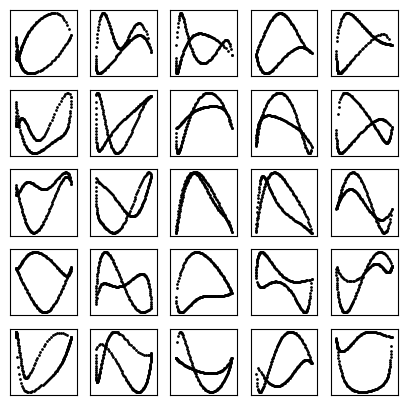

In [23]:
# image plotter check
def plot_generated(gen):
	noise = get_generator_noise(25)
	latent = get_generator_2d_uniform_latent(5)
	gen_output = gen(noise, latent)[-1].detach().cpu()
	linear_plotter(gen_output)
	plt.show()
plot_generated(generator)

  0%|          | 0/1500 [00:00<?, ?it/s]

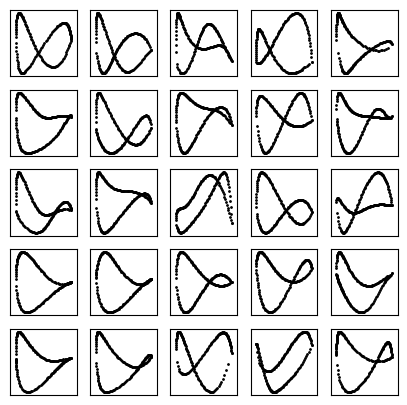

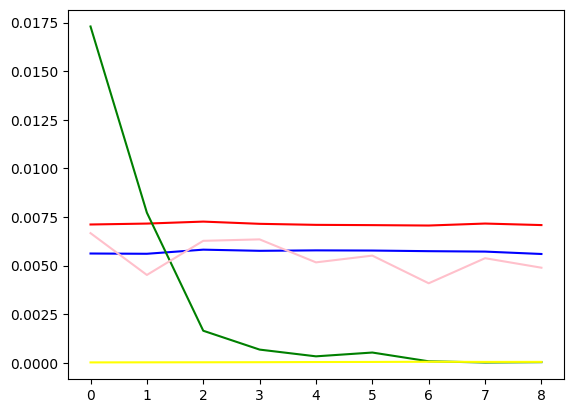

  3%|▎         | 50/1500 [02:21<1:03:19,  2.62s/it]

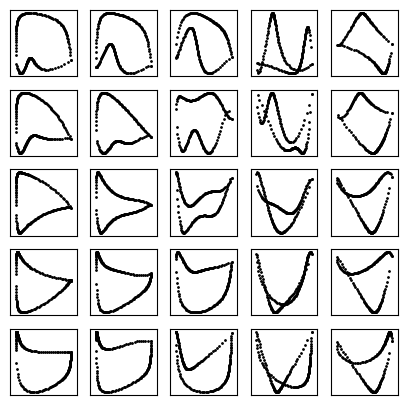

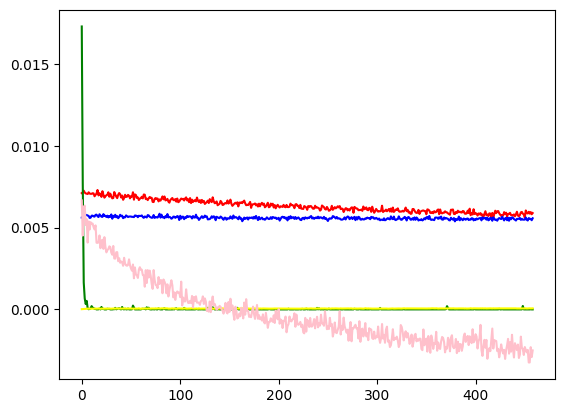

  7%|▋         | 100/1500 [04:42<1:11:05,  3.05s/it]

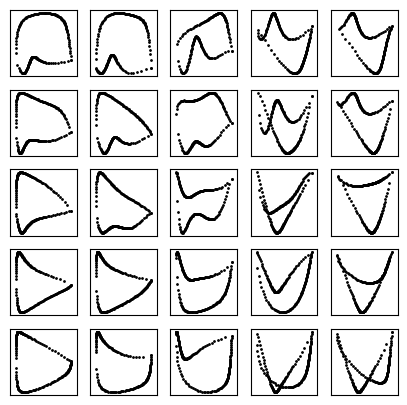

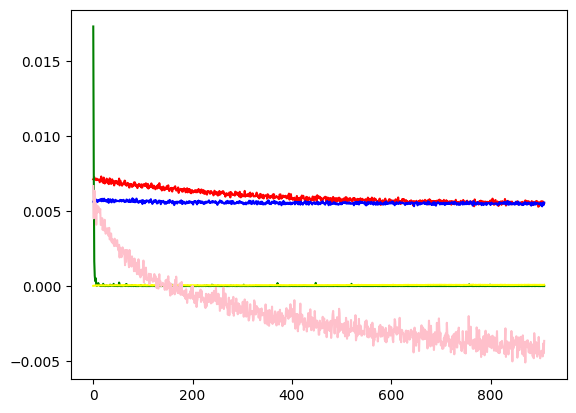

 10%|█         | 150/1500 [07:13<1:04:04,  2.85s/it]

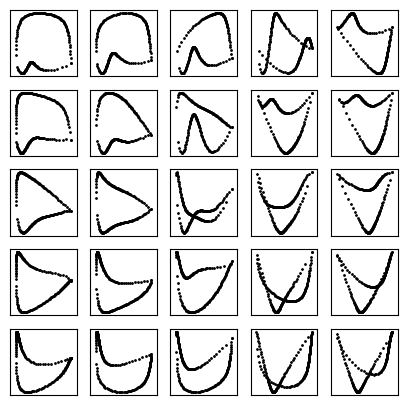

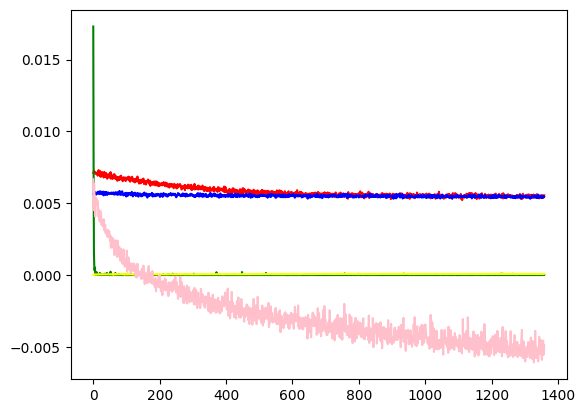

 13%|█▎        | 200/1500 [09:43<1:00:25,  2.79s/it]

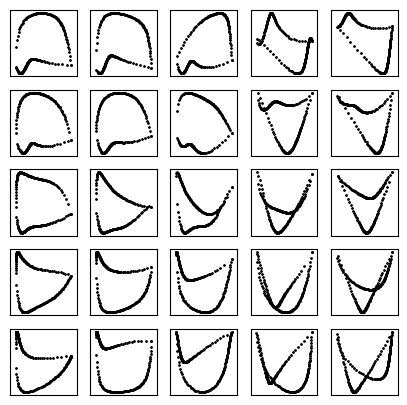

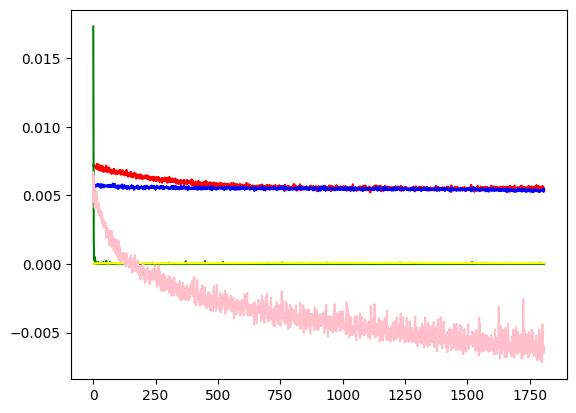

 17%|█▋        | 250/1500 [12:09<58:04,  2.79s/it]  

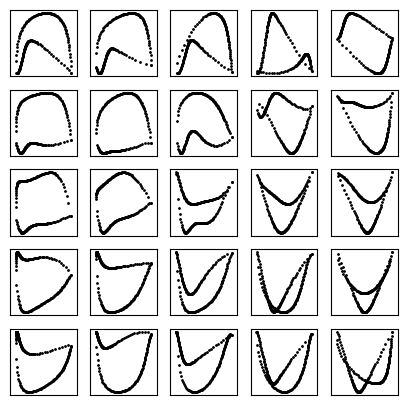

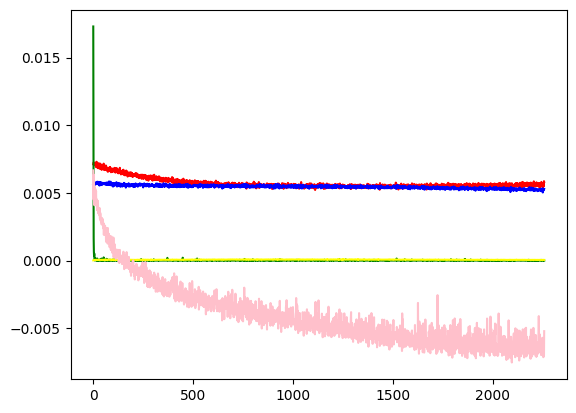

 20%|██        | 300/1500 [14:38<57:55,  2.90s/it]  

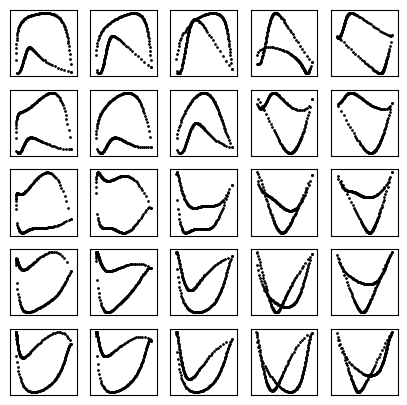

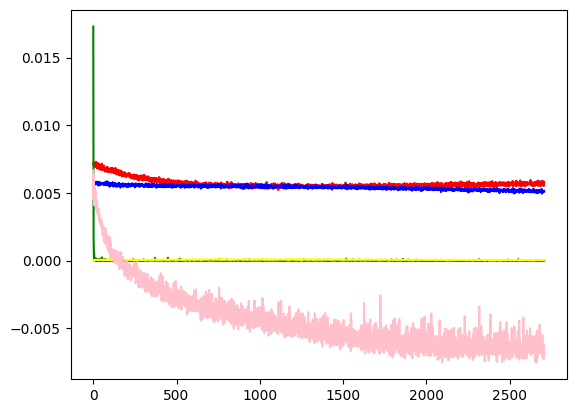

 23%|██▎       | 350/1500 [17:05<58:24,  3.05s/it]  

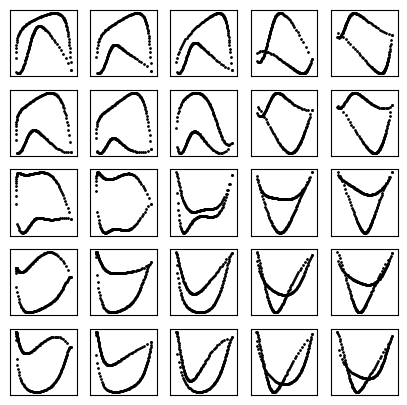

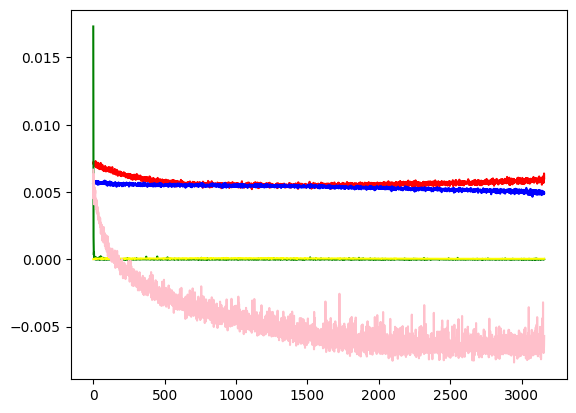

 27%|██▋       | 400/1500 [19:07<41:50,  2.28s/it]  

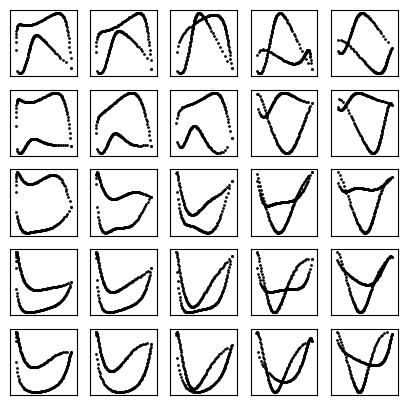

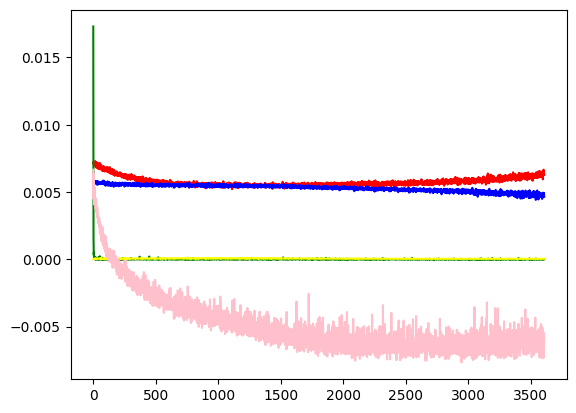

 30%|███       | 450/1500 [21:06<42:31,  2.43s/it]

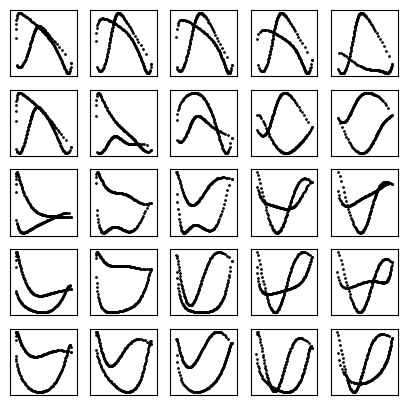

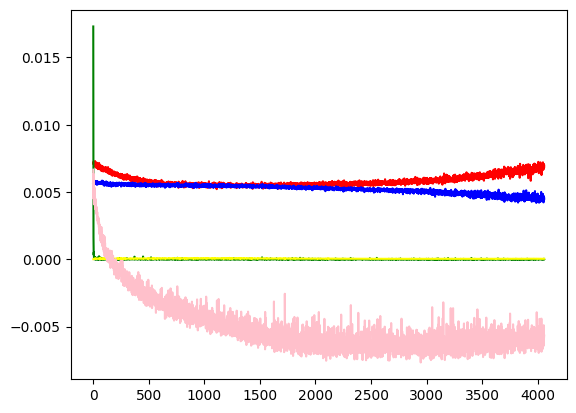

 33%|███▎      | 500/1500 [23:30<52:22,  3.14s/it]

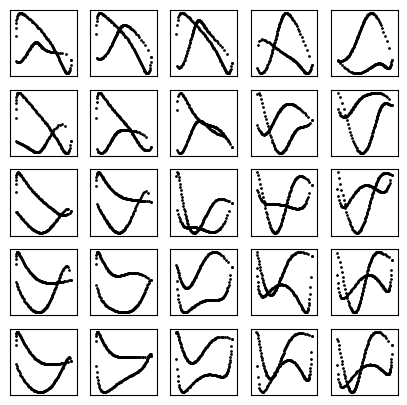

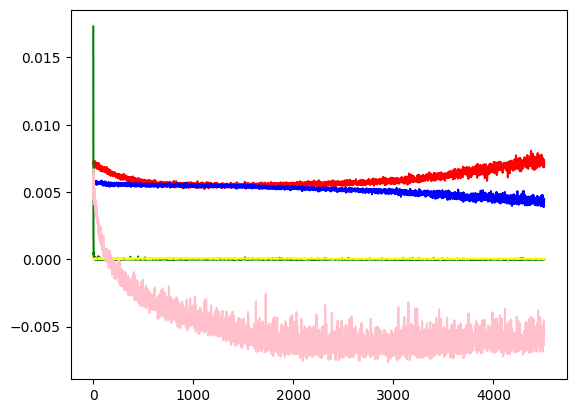

 37%|███▋      | 550/1500 [26:03<42:20,  2.67s/it]

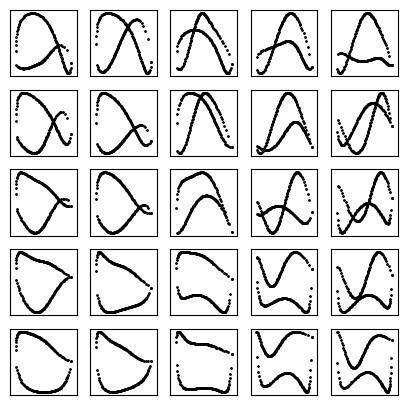

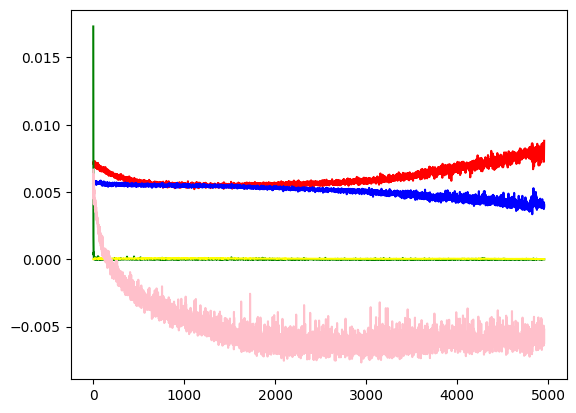

 40%|████      | 600/1500 [28:21<43:51,  2.92s/it]

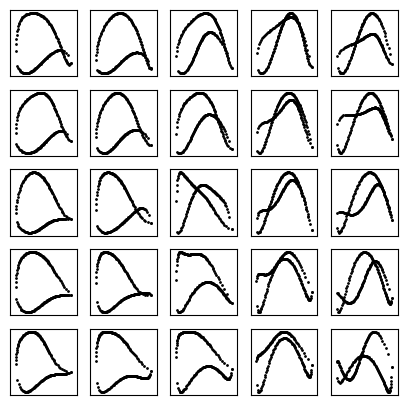

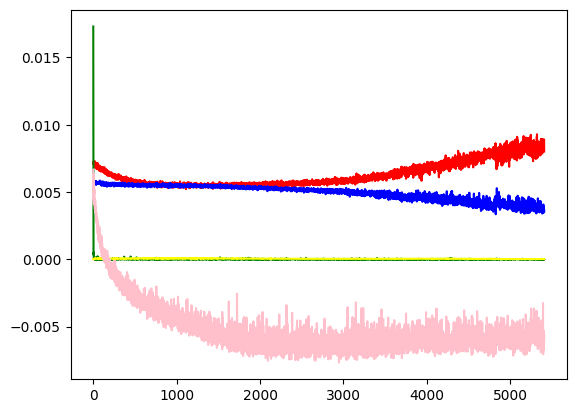

 43%|████▎     | 650/1500 [30:40<40:54,  2.89s/it]

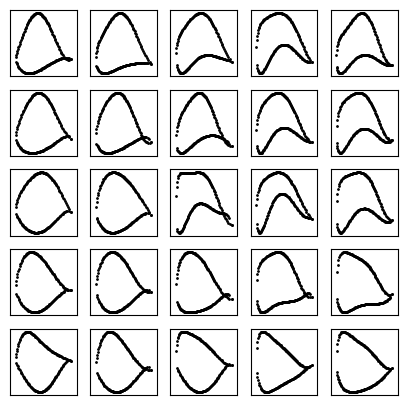

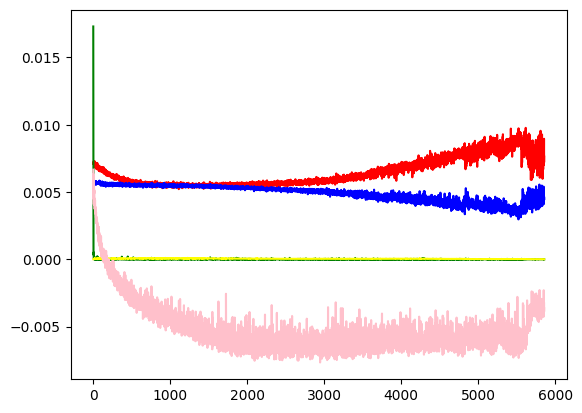

 47%|████▋     | 700/1500 [33:01<38:05,  2.86s/it]

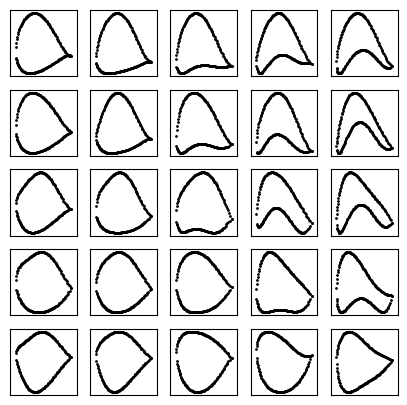

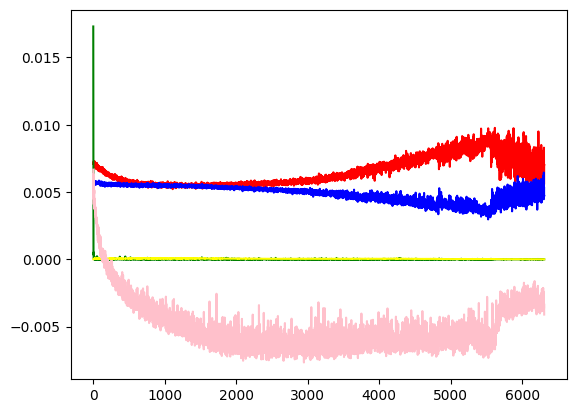

 50%|█████     | 750/1500 [35:28<36:13,  2.90s/it]

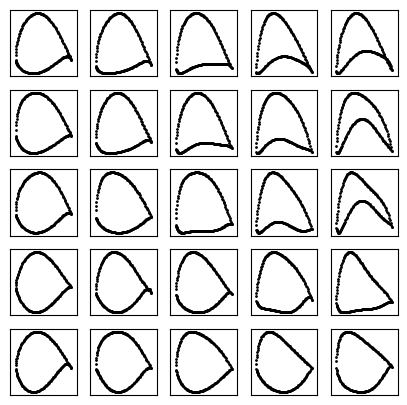

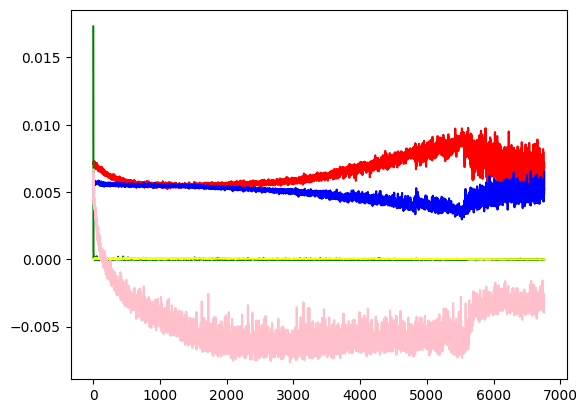

 53%|█████▎    | 800/1500 [37:42<27:59,  2.40s/it]

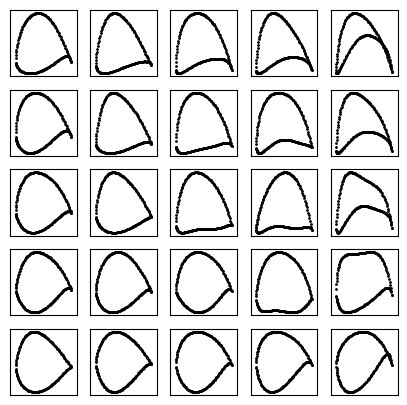

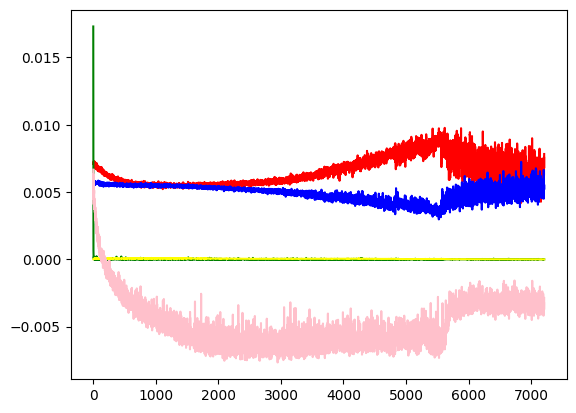

 57%|█████▋    | 850/1500 [40:07<37:40,  3.48s/it]

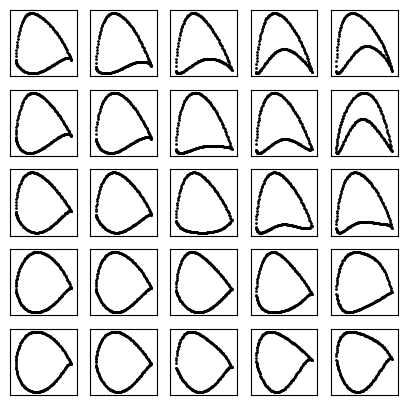

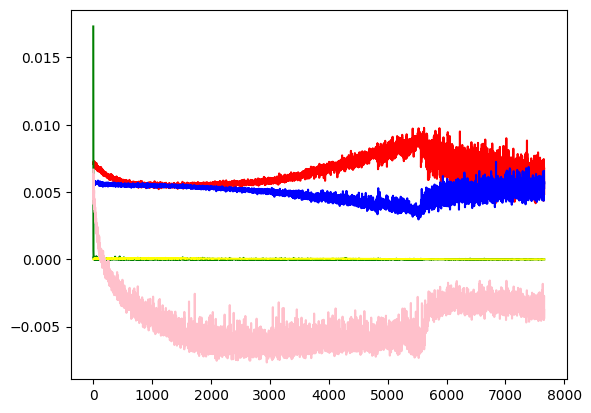

 60%|██████    | 900/1500 [43:05<38:10,  3.82s/it]

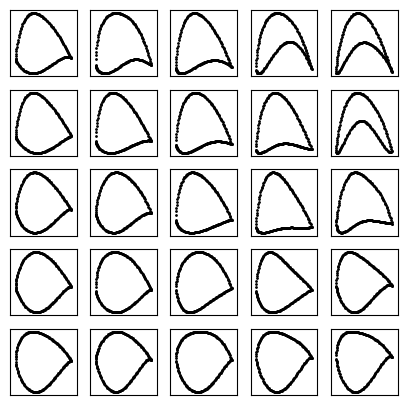

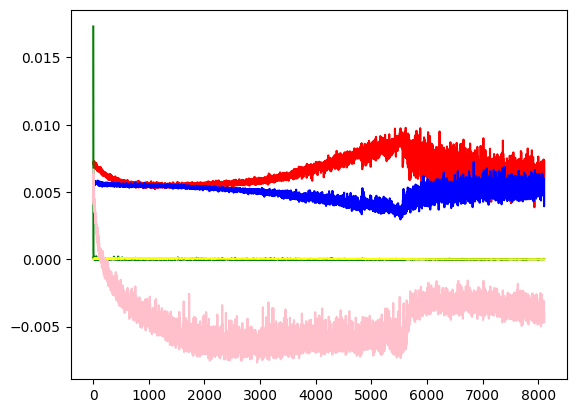

 63%|██████▎   | 950/1500 [46:06<33:52,  3.70s/it]

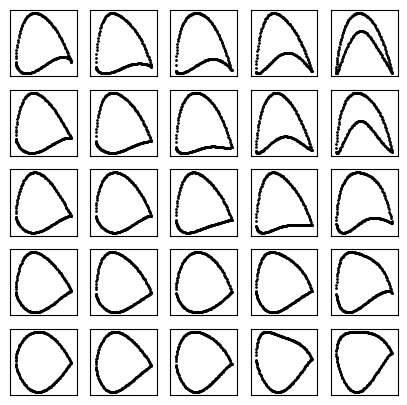

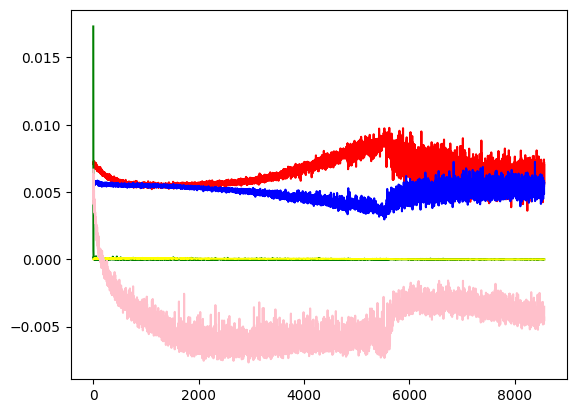

 67%|██████▋   | 1000/1500 [49:11<31:46,  3.81s/it]

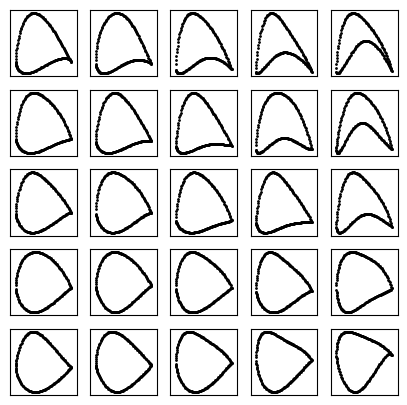

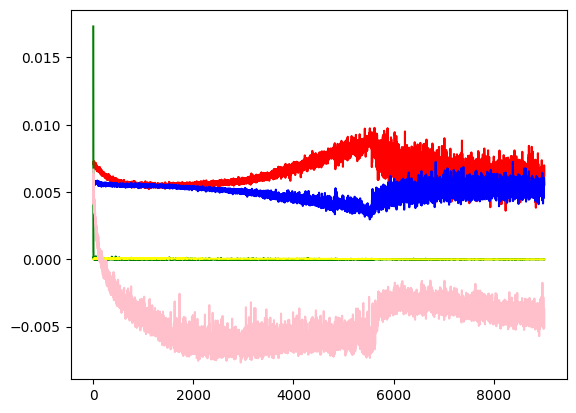

 70%|███████   | 1050/1500 [52:32<32:33,  4.34s/it]

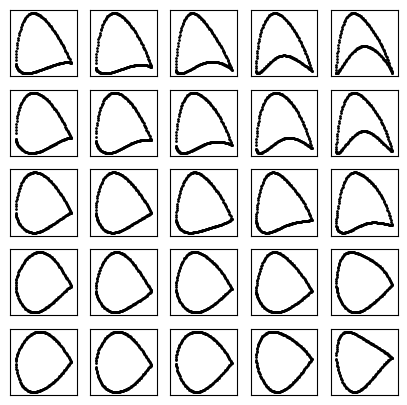

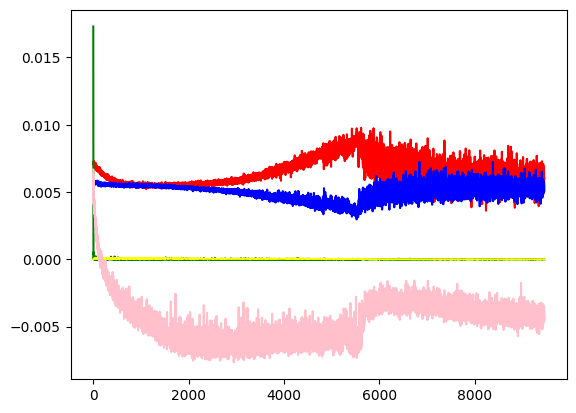

 73%|███████▎  | 1100/1500 [56:02<27:44,  4.16s/it]

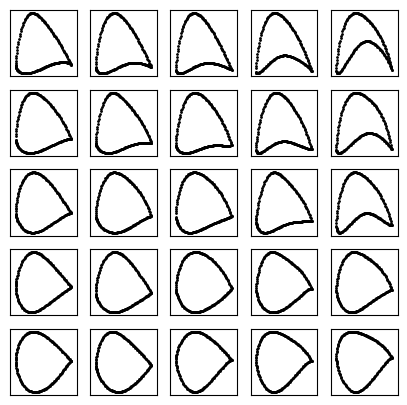

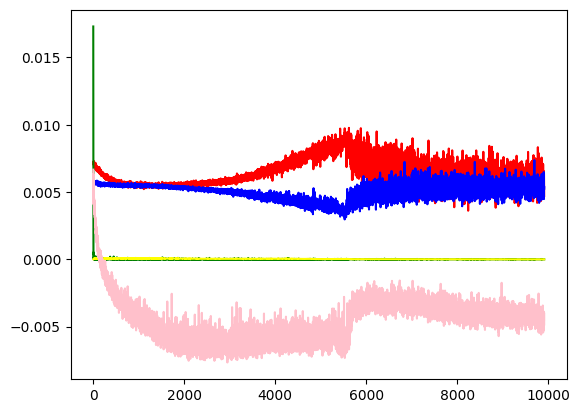

 74%|███████▎  | 1105/1500 [56:24<27:50,  4.23s/it]

In [24]:
# Training Loop

img_list = []
G_losses = []
D_losses = []
C_losses = []
Q_losses = []
S_losses = []

iters = 0
cur_step = 0
img_show = 3

start_time= time.time()
for epoch in tqdm(range(num_epochs)):

  for real in (train_loader):
    cur_batch_size = len(real)
    real = real.to(device)

    optimD.zero_grad()

    disc_loss = get_discriminator_loss(generator, discriminator, netD, criterionD, real, cur_batch_size)

    disc_loss.backward()

    optimD.step()


    optimG.zero_grad()
    curve_loss, sample_loss, gen_loss, query_loss = get_generator_loss(generator, discriminator, netD, netQ, num_images=cur_batch_size)
    # gen_loss = get_generator_loss(generator, discriminator, netD, criterionD, cur_batch_size)
    # gen_loss.backward()
    # curve_loss = get_generator_curve_loss(generator, 10, cur_batch_size//5)
    # curve_loss.backward()
    # sample_loss = get_generator_sample_point_loss(generator, cur_batch_size//5)
    # sample_loss.backward()
    # query_loss = get_q_loss(generator, discriminator, netQ, criterionQ, cur_batch_size)
    # query_loss.backward()
    generator_loss = curve_loss * 1e1 + sample_loss + gen_loss + query_loss * 2
    generator_loss.backward()
    optimG.step()

    D_losses.append(disc_loss.item() / cur_batch_size)
    G_losses.append(gen_loss.item() / cur_batch_size)
    C_losses.append(curve_loss.item() / cur_batch_size)
    S_losses.append(sample_loss.item() / cur_batch_size)
    Q_losses.append(query_loss.item() / cur_batch_size)


  if epoch%50==0:
    with torch.no_grad():
      plot_generated(generator)
    plt.figure()
    plt.ylim(-0.01, 0.015)
    plt.plot(G_losses, c='red')
    plt.plot(D_losses, c='blue')
    plt.plot(C_losses, c='green')
    plt.plot(S_losses, c='yellow')
    plt.plot(Q_losses, c='pink')
    # print(C_losses)
    plt.show()
end= time.time() - start_time
print('time for train: ', end/3600 , 'hours')